## Load Modules/Data and Show Initial Tables

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

sns.set(style='ticks', color_codes=True) 

from os.path import isfile

from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Model Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Load the datasets
root_path = './datasets/titanic/'

train_path = root_path + 'train.csv'
test_path = root_path + 'test.csv'

paths = [train_path, test_path]

for path in paths:
    if not isfile(path):
        print(f"Dataset {path} not found. Please check that the dataset exists and the path is correct.")
        
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
    
def show_tables(n=10):
    display(train.head(n))
    display(test.head(n))
    
# Show the tables
show_tables()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


## Cleanup Data

### Drop non-essential and sparse data features

I had some duplicate checking here earlier, but I removed it because there don't appear to be duplicates in the data. That could be from clerical errors, but my results are pretty good.

In [2]:
# Name and ID are just useless identifiers. Name gives us some social class info so let's wait a bit to remove it.
# Ticket and Cabin might be useful if there was a correlation with cabin position and 
# survivability but they're pretty sparse. Fare should also correlate extremely well with these, 
# so I don't think they're necessary at all.

useless = ['PassengerId', 'Ticket', 'Cabin']

# Extract Passenger IDs
train_ids = pd.DataFrame(train['PassengerId'])
test_ids = pd.DataFrame(test['PassengerId'])

print(train_ids)

train.drop(columns=useless, inplace=True)
test.drop(columns=useless, inplace=True)

# Show the adjusted tables
show_tables()

# Show types
display(train.dtypes)
display(test.dtypes)

     PassengerId
0              1
1              2
2              3
3              4
4              5
..           ...
886          887
887          888
888          889
889          890
890          891

[891 rows x 1 columns]


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,8.4583,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,C


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S
5,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,9.2250,S
6,3,"Connolly, Miss. Kate",female,30.0,0,0,7.6292,Q
7,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,29.0000,S
8,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,7.2292,C
9,3,"Davies, Mr. John Samuel",male,21.0,2,0,24.1500,S


Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

### Reduce Name Data

Gonna get the titles out of the name data (e.g. 'Mr.' 'Miss.', 'Col.', etc.). We're also going to combine the French and the English.

In [3]:
french_dict = {'Mme.': 'Mrs.', 'Mlle.': 'Miss.'}

upper_class = ['Don.', 'Countess.', 'Capt.', 'Jonkheer.', 'Dona.', 'Col.', 'Lady.', 'Major.', 'Sir.']

def get_titles(name):
    title_exp = r'[A-Za-z \-\']+,[A-Za-z\s]*\s(?P<Title>[A-Za-z]+\.)\s+.+'
    title_exp = re.compile(title_exp)

    match = title_exp.match(name)
    if match:
        title = match.group('Title')

        # Apply French dictionary for those passengers
        title = title if title not in french_dict else french_dict[title]
        
        # Collapse Lordship/Military into one class
        title = title if title not in upper_class else 'Upper.'
        
        return title
    
    else:
        print(name)
        return ''

# Extract titles into
train['Title'] = train['Name'].apply(get_titles)
test['Title'] = test['Name'].apply(get_titles)

train.drop(columns=['Name'], inplace=True)
test.drop(columns=['Name'], inplace=True)

### Check for Missing Data

In [4]:
# Check for nulls
display("Train Nulls?", train.isnull().any())
display("Test Nulls?", test.isnull().any())

'Train Nulls?'

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Embarked     True
Title       False
dtype: bool

'Test Nulls?'

Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare         True
Embarked    False
Title       False
dtype: bool

In [5]:
# Found nulls in train['Age'], test['Age'], and test['Fare']
display("Train Nulls")
display(train[train['Age'].isnull()].head())

display("Test Nulls")
display(test[test['Age'].isnull()].head())
display(test[test['Fare'].isnull()].head())

'Train Nulls'

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
5,0,3,male,NaN,0,0,8.4583,Q,Mr.
17,1,2,male,NaN,0,0,13.0000,S,Mr.
19,1,3,female,NaN,0,0,7.2250,C,Mrs.
26,0,3,male,NaN,0,0,7.2250,C,Mr.
28,1,3,female,NaN,0,0,7.8792,Q,Miss.


'Test Nulls'

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
10,3,male,NaN,0,0,7.8958,S,Mr.
22,1,female,NaN,0,0,31.6833,S,Mrs.
29,3,male,NaN,2,0,21.6792,C,Mr.
33,3,female,NaN,1,2,23.4500,S,Mrs.
36,3,female,NaN,0,0,8.0500,S,Miss.


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
152,3,male,60.5,0,0,NaN,S,Mr.


### Discretize data

Only thing that needs to be discretized after dropping columns is 'Sex'

In [6]:
# Taken from module 3 notebook
def encode_onehot(df, f):
    df2 = pd.get_dummies(df[f], prefix='', prefix_sep='').max(level=0, axis=1).add_prefix(f+' - ')
    df3 = pd.concat([df, df2], axis=1)
    df3 = df3.drop([f], axis=1)
    return df3

discretize = ['Sex', 'Title', 'Embarked']

for dis in discretize:
    if dis in train:
        train = encode_onehot(train, dis)
        test = encode_onehot(test, dis)

### Impute missing values with k-Nearest Neighbors Imputer

In [7]:
# Impute nulls with KNN imputation
imputer = KNNImputer()

train_knn = imputer.fit_transform(train)
test_knn = imputer.fit_transform(test)

train_knn = pd.DataFrame(train_knn)
test_knn = pd.DataFrame(test_knn)

train_knn.columns = train.columns
test_knn.columns = test.columns

train = train_knn
test = test_knn

# check our work
display(train.isnull().any())
display(test.isnull().any())

# Show the current state of the table
show_tables()

Survived           False
Pclass             False
Age                False
SibSp              False
Parch              False
Fare               False
Sex - female       False
Sex - male         False
Title - Dr.        False
Title - Master.    False
Title - Miss.      False
Title - Mr.        False
Title - Mrs.       False
Title - Ms.        False
Title - Rev.       False
Title - Upper.     False
Embarked - C       False
Embarked - Q       False
Embarked - S       False
dtype: bool

Pclass             False
Age                False
SibSp              False
Parch              False
Fare               False
Sex - female       False
Sex - male         False
Title - Dr.        False
Title - Master.    False
Title - Miss.      False
Title - Mr.        False
Title - Mrs.       False
Title - Ms.        False
Title - Rev.       False
Title - Upper.     False
Embarked - C       False
Embarked - Q       False
Embarked - S       False
dtype: bool

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex - female,Sex - male,Title - Dr.,Title - Master.,Title - Miss.,Title - Mr.,Title - Mrs.,Title - Ms.,Title - Rev.,Title - Upper.,Embarked - C,Embarked - Q,Embarked - S
0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,3.0,47.8,0.0,0.0,8.4583,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,1.0,54.0,0.0,0.0,51.8625,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,3.0,2.0,3.0,1.0,21.0750,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1.0,3.0,27.0,0.0,2.0,11.1333,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,1.0,2.0,14.0,1.0,0.0,30.0708,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


,Pclass,Age,SibSp,Parch,Fare,Sex - female,Sex - male,Title - Dr.,Title - Master.,Title - Miss.,Title - Mr.,Title - Mrs.,Title - Ms.,Title - Rev.,Title - Upper.,Embarked - C,Embarked - Q,Embarked - S
0,3.0,34.5,0.0,0.0,7.8292,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.0,47.0,1.0,0.0,7.0000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.0,62.0,0.0,0.0,9.6875,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.0,27.0,0.0,0.0,8.6625,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,22.0,1.0,1.0,12.2875,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,3.0,14.0,0.0,0.0,9.2250,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,3.0,30.0,0.0,0.0,7.6292,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,2.0,26.0,1.0,1.0,29.0000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,3.0,18.0,0.0,0.0,7.2292,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,3.0,21.0,2.0,0.0,24.1500,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
# Test df now is missing columns, so let's cleanup the data a bit.

# Get the title columns
titles = list(train.columns) + list(test.columns)
titles = list(set(titles))
titles = [title for title in titles if title.startswith('Title')]
print(titles)

def add_titles(df, titles=titles):
    for title in titles:
        if title not in df.columns:
            df[title] = [0]*len(df)
            
    return df.reindex(sorted(df.columns), axis=1)

            
train = add_titles(train)
test = add_titles(test)
show_tables()

['Title - Miss.', 'Title - Mrs.', 'Title - Dr.', 'Title - Master.', 'Title - Rev.', 'Title - Ms.', 'Title - Upper.', 'Title - Mr.']


,Age,Embarked - C,Embarked - Q,Embarked - S,Fare,Parch,Pclass,Sex - female,Sex - male,SibSp,Survived,Title - Dr.,Title - Master.,Title - Miss.,Title - Mr.,Title - Mrs.,Title - Ms.,Title - Rev.,Title - Upper.
0,22.0,0.0,0.0,1.0,7.2500,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,38.0,1.0,0.0,0.0,71.2833,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,26.0,0.0,0.0,1.0,7.9250,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,35.0,0.0,0.0,1.0,53.1000,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,35.0,0.0,0.0,1.0,8.0500,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,47.8,0.0,1.0,0.0,8.4583,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,54.0,0.0,0.0,1.0,51.8625,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,2.0,0.0,0.0,1.0,21.0750,1.0,3.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,27.0,0.0,0.0,1.0,11.1333,2.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,14.0,1.0,0.0,0.0,30.0708,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,Age,Embarked - C,Embarked - Q,Embarked - S,Fare,Parch,Pclass,Sex - female,Sex - male,SibSp,Title - Dr.,Title - Master.,Title - Miss.,Title - Mr.,Title - Mrs.,Title - Ms.,Title - Rev.,Title - Upper.
0,34.5,0.0,1.0,0.0,7.8292,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,47.0,0.0,0.0,1.0,7.0000,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,62.0,0.0,1.0,0.0,9.6875,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,27.0,0.0,0.0,1.0,8.6625,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,22.0,0.0,0.0,1.0,12.2875,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,14.0,0.0,0.0,1.0,9.2250,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,30.0,0.0,1.0,0.0,7.6292,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,26.0,0.0,0.0,1.0,29.0000,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,18.0,1.0,0.0,0.0,7.2292,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,21.0,0.0,0.0,1.0,24.1500,0.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Construct and Run Pipeline

Of the models tested, RBF SVC with default parameters runs best overall with a mean cross validated accuracy of around 83%

In [14]:
# Prepare training set
x = train.loc[:, train.columns != 'Survived'].values
y = train.loc[:, train.columns == 'Survived'].values.ravel()

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Model Declaration
models = [KNeighborsClassifier(), LogisticRegression(), GaussianNB(), 
          DecisionTreeClassifier(), RandomForestClassifier(), SVC(C=4)]
accuracies = []
p_lines = {}

# Construct Pipeline and Train/Test
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for model in models:
    pipe_lr = make_pipeline(StandardScaler(), model)
    pipe_lr.fit(x, y)
    
    score = cross_val_score(pipe_lr, x, y, cv=kfold, scoring='accuracy')

    accuracies.append((type(model), np.mean(score)))
       
    p_lines[type(model)] = pipe_lr

# Sort by the mean of the accuracies
accuracies.sort(key=lambda x: np.mean(x[1]), reverse=True)
display(accuracies)

[(sklearn.linear_model._logistic.LogisticRegression, 0.8271660424469414),
 (sklearn.svm._classes.SVC, 0.8271535580524345),
 (sklearn.ensemble._forest.RandomForestClassifier, 0.8136953807740325),
 (sklearn.neighbors._classification.KNeighborsClassifier, 0.812546816479401),
 (sklearn.tree._classes.DecisionTreeClassifier, 0.8046691635455681),
 (sklearn.naive_bayes.GaussianNB, 0.7586516853932583)]

## Export for Kaggle

In [10]:
def save_preds(_fn, _y_pred, _df):
    import csv
    with open(_fn, 'w') as fout:
        writer = csv.writer(fout, delimiter=',', lineterminator='\n')
        writer.writerow(['PassengerId', 'Survived'])
        for y, passengerId in zip(_y_pred, _df['PassengerId']):
            writer.writerow([passengerId, y])
            
# Get the predicition with the best model
y_pred = p_lines[accuracies[0][0]].predict(test).astype(np.int)
# Save predictions
save_preds('predictions_mcelhenney.csv', y_pred, test_ids)

## Kaggle Results

I think I may have been able to get slightly better results by extracting Cabin data as well (despite how sparse it was). 

RBF SVC tends to yield the best results and changes to its parameters don't seem to yield better results.

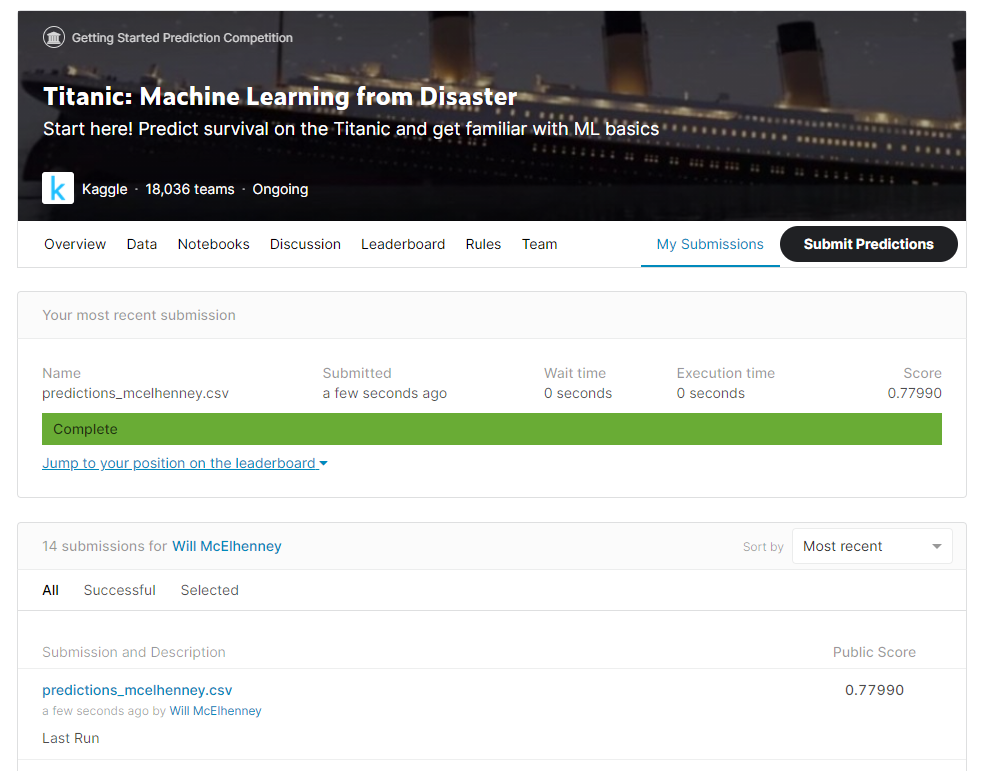